In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
%matplotlib inline


In [81]:

#print(lastdate)

def get_timeseries(date):
    datestr = date.strftime('%m-%d-%Y')
    filename = '/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/' + datestr + '.csv'
    result = pd.read_csv(filename)
    result['Date'] = date
    return result

def get_daily_report_data():
    start_date_for_daily_data = datetime(2020, 4, 12)
    current_date = start_date_for_daily_data

    yesterday = (datetime.now() + timedelta(days = -1))
    lastdate = yesterday.strftime('%m-%d-%Y')
    
    series = pd.DataFrame()

    while True:
        series = series.append(get_timeseries(current_date))
        current_date = current_date + timedelta(days = 1)
        if current_date > yesterday:
            break
    
    
    return series

def smooth_bad_cumulative_values(series, columnname):
    
    states = np.sort(series['Province_State'].unique())
    
    for state in states:
        stateseries = series[series['Province_State'] == state]

        cumulative = stateseries[columnname].cummax()

        series.loc[(series['Province_State'] == state) & (stateseries[columnname] < cumulative), columnname] = np.nan
        
        interpolation = series[series['Province_State'] == state][columnname].interpolate()
        
        series.loc[series['Province_State'] == state, columnname] = interpolation

    return series;

def clean_daily_report_data(series):
    series.reset_index(inplace=True)
    series = series.dropna(subset=['People_Tested', 'Confirmed']).copy()
    
    series = smooth_bad_cumulative_values(series, 'People_Tested')
    series = smooth_bad_cumulative_values(series, 'Confirmed')
    
    
    series['NewConfirmed'] = series.sort_values(by=['Date']).groupby(['Province_State'])['Confirmed'].transform(pd.Series.diff).fillna(0)
    series['NewTests'] = series.sort_values(by=['Date']).groupby(['Province_State'])['People_Tested'].transform(pd.Series.diff).fillna(0)
    
    series['NewConfirmedVsTests'] = series['NewConfirmed'].div(series['NewTests']).dropna()
    #print(series[series['Province_State'] == 'Louisiana'][['People_Tested', 'Confirmed', 'NewTests', 'NewConfirmed', 'NewConfirmedVsTests']])
    
    series = series.replace([np.inf, -np.inf], np.nan).dropna(subset=['NewConfirmedVsTests'])
    series = series.set_index(['Province_State', 'Date'])

    rollingrate = 7
    series['Rolling'] = pd.DataFrame(series.groupby('Province_State', as_index=False)['NewConfirmed'].rolling(rollingrate).sum()).reset_index().set_index(['Province_State', 'Date'])['NewConfirmed'].div(pd.DataFrame(series.groupby('Province_State', as_index=False)['NewTests'].rolling(rollingrate).sum()).reset_index().set_index(['Province_State', 'Date'])['NewTests'])
    series['TestAvailability'] = pd.DataFrame(series.groupby('Province_State', as_index=False)['Testing_Rate'].rolling(rollingrate).mean()).reset_index().set_index(['Province_State', 'Date'])['Testing_Rate']
    series['RollingStd'] = pd.DataFrame(series.groupby('Province_State', as_index=False)['NewConfirmedVsTests'].rolling(rollingrate).std()).reset_index().set_index(['Province_State', 'Date'])['NewConfirmedVsTests']
    series['RollingCV'] = series['RollingStd'].div(series['Rolling'])

    
    series = series.reset_index()
    
    #print(series[series['Province_State'] == 'Louisiana'][['People_Tested', 'Confirmed', 'NewTests', 'NewConfirmed', 'NewConfirmedVsTests', 'Rolling']])
    
 
    return series;


original_series = get_daily_report_data();    
series = original_series.copy()
series = clean_daily_report_data(series)


# 7-Day Rolling Averages of Confirmed Percentage for all US States & Territories

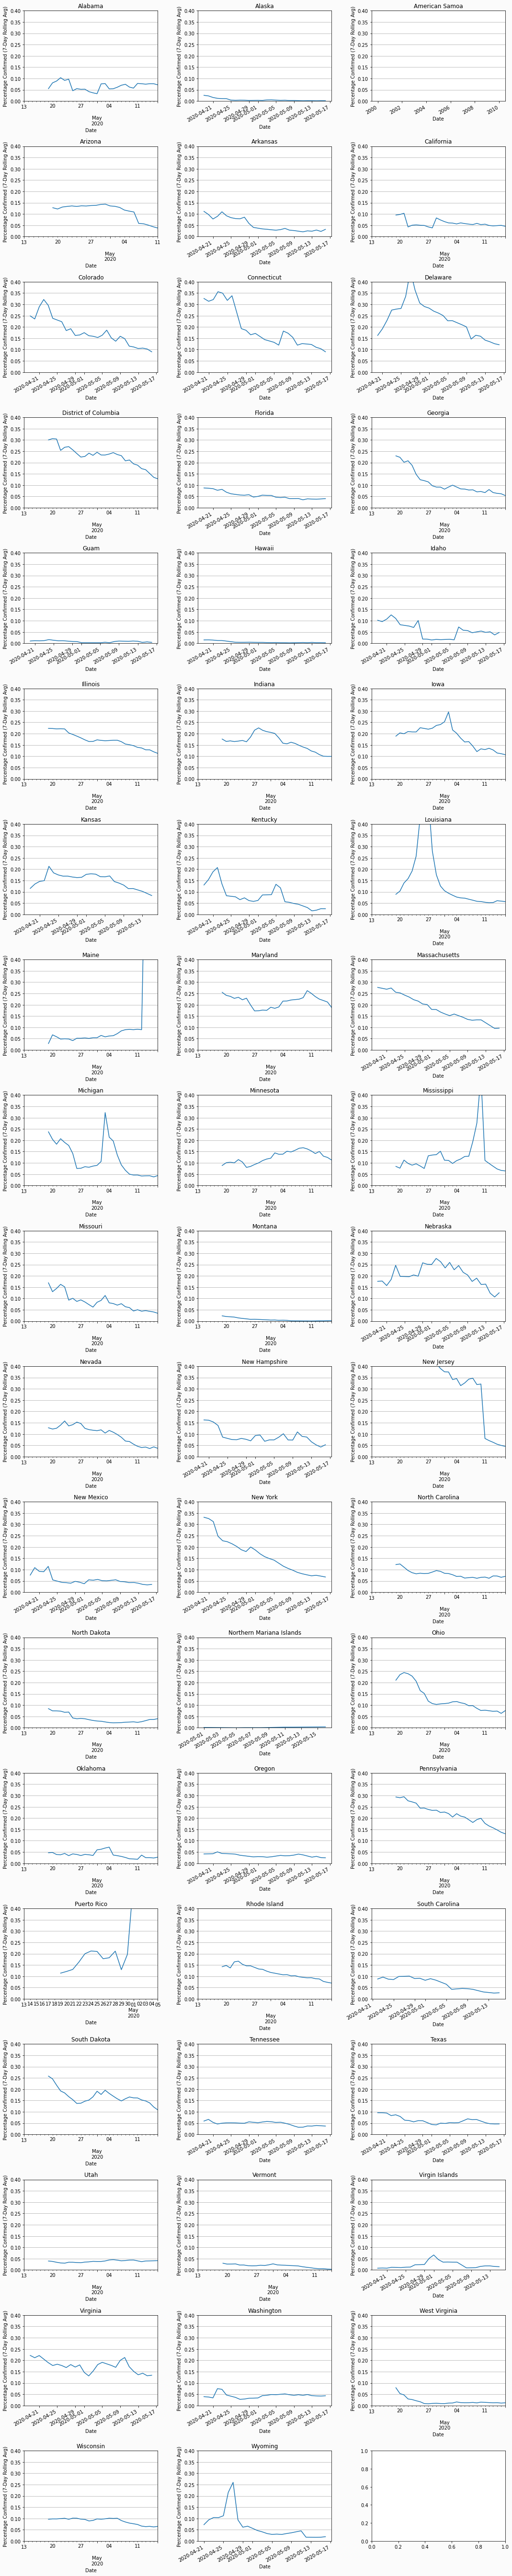

In [80]:
states = np.sort(series['Province_State'].unique())

fig, axes = plt.subplots(19, 3, figsize=(18, 18*6), gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, facecolor='#fbfbfb')

axesflat = axes.flatten()

i = 0;

printmd('# 7-Day Rolling Averages of Confirmed Percentage for all US States & Territories')
for state in states:

    statedata = series[series['Province_State'] == state].copy()

    ax = axesflat[i]
    i = i + 1
    
    ax = statedata.plot.line(x='Date', y='Rolling', ylim=(0, 0.4), ax=ax, legend=False)
    ax.set_ylabel('Percentage Confirmed (7-Day Rolling Avg)')
    ax.yaxis.grid()
    ax.set_title(state)

In [26]:
series[series['Province_State'] == 'Louisiana'][['People_Tested', 'NewConfirmed', 'NewTests']]

,People_Tested,NewConfirmed,NewTests
18,118422.0,502.0,10331.0
71,121928.0,433.0,3506.0
126,126586.0,581.0,4658.0
181,131987.0,586.0,5401.0
236,137999.0,462.0,6012.0
291,141504.0,348.0,3505.0
346,142099.0,595.0,595.0
401,142430.0,331.0,331.0
456,142834.0,404.0,404.0
511,143315.0,481.0,481.0


# 7-Day Rolling Tests Performed Per 100,000 People

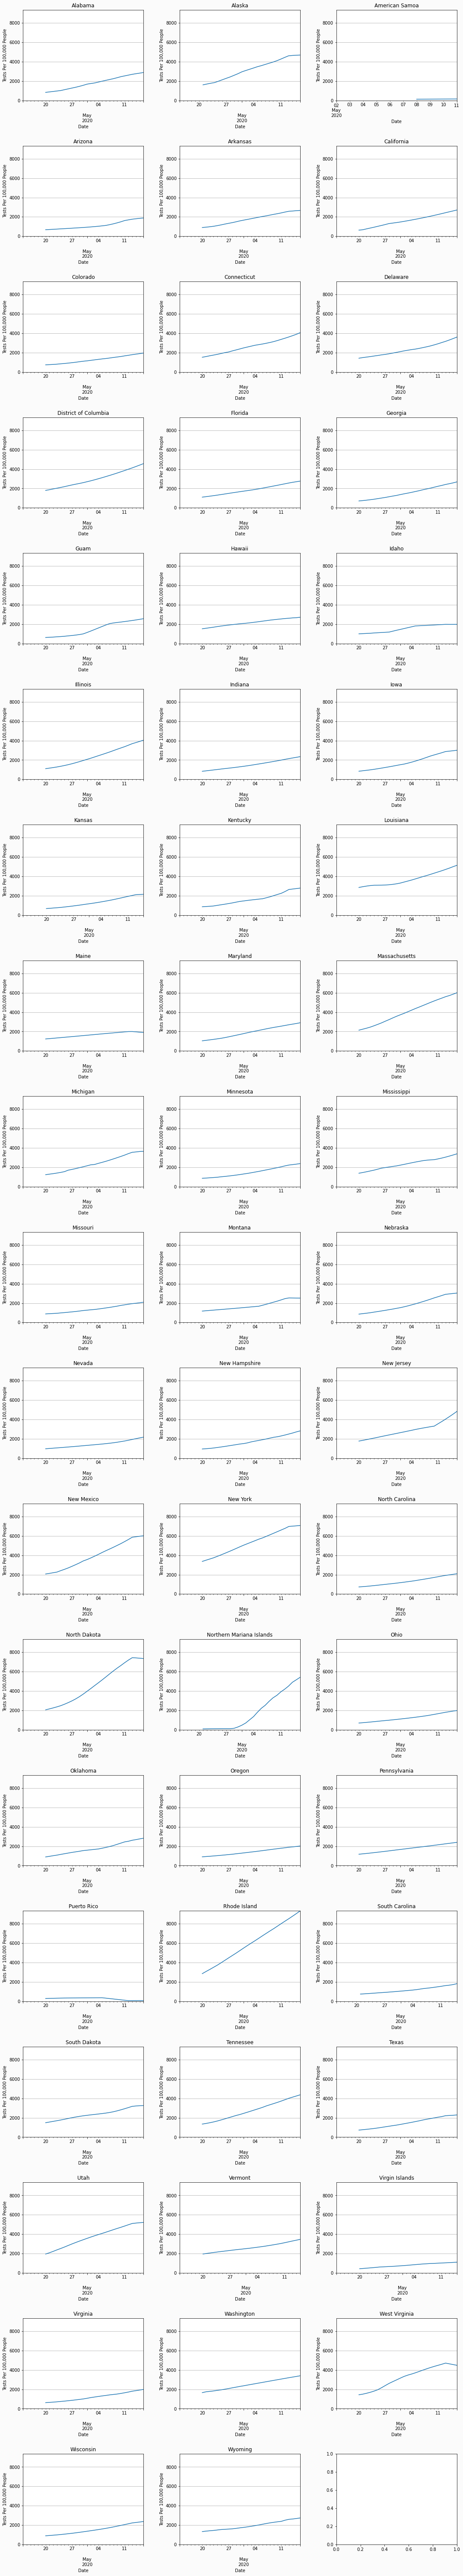

In [17]:
states = np.sort(series['Province_State'].unique())

fig, axes = plt.subplots(19, 3, figsize=(18, 18*6), gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, facecolor='#fbfbfb')

axesflat = axes.flatten()

i = 0;

ymax = series['TestAvailability'].max()

printmd('# 7-Day Rolling Tests Performed Per 100,000 People')
for state in states:

    statedata = series[series['Province_State'] == state].copy()

    ax = axesflat[i]
    i = i + 1
    
    ax = statedata.plot.line(x='Date', y='TestAvailability', ylim=(0, ymax), ax = ax, legend=False)
    ax.set_ylabel('Tests Per 100,000 People')
    ax.yaxis.grid()
    ax.set_title(state)

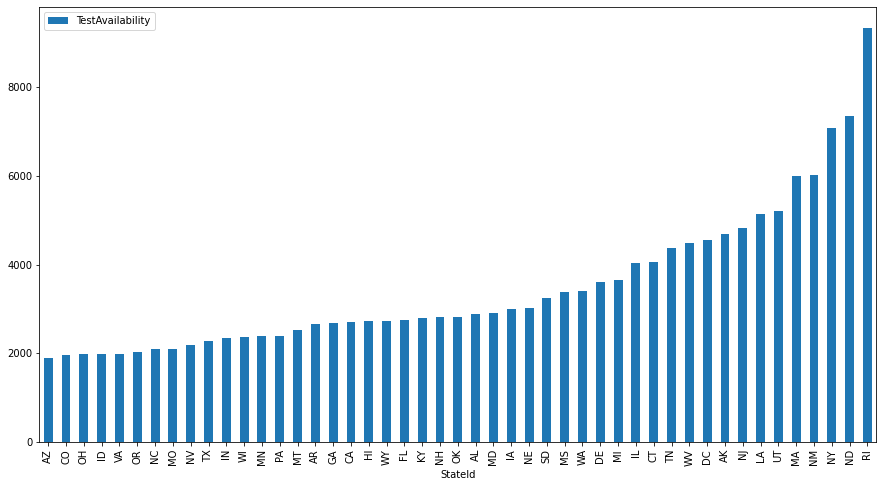

In [12]:
yesterday = (datetime.now() + timedelta(days = -1))
lastdate = yesterday.strftime('%m-%d-%Y')
    
yesterdaydata = series[series['Date'] == lastdate].copy()

yesterdaydata.index = yesterdaydata['Province_State']
raw_state_abbreviations = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
raw_state_abbreviations.index = raw_state_abbreviations['State']

raw_state_abbreviations
yesterdaydata['StateId'] = raw_state_abbreviations['Abbreviation']

yesterdaydata = yesterdaydata.dropna(subset=['StateId'], axis=0)

# cutoff at half the population. Most states won't have levels above this without also having bad data. 
yesterdaydata = yesterdaydata[yesterdaydata['Rolling'] < 0.5]


fig = go.Figure(data=go.Choropleth(
    locations=yesterdaydata['StateId'], # Spatial coordinates
    z = yesterdaydata['Rolling'].astype(float) * 100, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Percent Positive"
))

fig.update_layout(
    title_text = 'Percent Positive USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

fig2 = go.Figure(data=go.Choropleth(
    locations=yesterdaydata['StateId'], # Spatial coordinates
    z = yesterdaydata['TestAvailability'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "People Tested per 100,000"
))

fig2.update_layout(
    title_text = 'Testing Rate',
    geo_scope='usa', # limite map scope to USA
)

fig2.show()

#fig, ax = plt.subplots()

plt.show(yesterdaydata.sort_values(by='TestAvailability').plot.bar(x = 'StateId', y='TestAvailability', figsize=(15,8)))
# This could be due to the availability of tests or it could be due to social distancing reducing things

# The stuff below can basically be ignored

In [67]:
throw throw throw

start_date_for_daily_data = datetime(2020, 4, 12)
current_date = start_date_for_daily_data

yesterday = (datetime.now() + timedelta(days = -1))
lastdate = yesterday.strftime('%m-%d-%Y')
#print(lastdate)

def get_timeseries(date):
    datestr = date.strftime('%m-%d-%Y')
    filename = '/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/' + datestr + '.csv'
    result = pd.read_csv(filename)
    result['Date'] = date
    return result

series = pd.DataFrame()

while True:
    series = series.append(get_timeseries(current_date))
    current_date = current_date + timedelta(days = 1)
    if current_date > yesterday:
        break

series.reset_index(inplace=True)
#series = series[series['Province_State'].isin(['Texas', 'Oklahoma'])]
series = series.dropna(subset=['People_Tested', 'Confirmed']).copy()
series = series.groupby(['Date']).sum()
#series[series.index.duplicated()]
series['NewConfirmed'] = series.sort_values(by=['Date'])['Confirmed'].transform(pd.Series.diff).fillna(0)
series['NewTests'] = series.sort_values(by=['Date'])['People_Tested'].transform(pd.Series.diff).fillna(0)
series['NewConfirmedVsTests'] = series['NewConfirmed'].div(series['NewTests']).dropna()
series = series.replace([np.inf, -np.inf], np.nan).dropna(subset=['NewConfirmedVsTests'])
series
#series = series.set_index(['Date'])

#texas['PercentConfirmedVsTested'] = texas['Confirmed'].div(texas['People_Tested'])
#texas
#series

pd.DataFrame(series['NewConfirmedVsTests'].rolling(7).mean())

series['Rolling'] = pd.DataFrame(series['NewConfirmedVsTests'].rolling(7).mean())
series['TestAvailability'] = pd.DataFrame(series['NewTests'].rolling(7).mean())
series['RollingStd'] = pd.DataFrame(series['NewConfirmedVsTests'].rolling(7).std())
series['RollingCV'] = series['RollingStd'].div(series['Rolling'])

#series
#series['Date'] = series.index
#series = series.reset_index()


#texas = series[series['Province_State'] == 'Texas'].copy()
#texas['NewvConfirmedRolling'] = pd.DataFrame(texas['NewConfirmedVsTests']).rolling(3)
series

SyntaxError: invalid syntax (<ipython-input-67-bd1bf7d67dca>, line 1)

Text(0.5, 1.0, 'US Coef. Variance of Positive Percent (7-Day Rolling)')

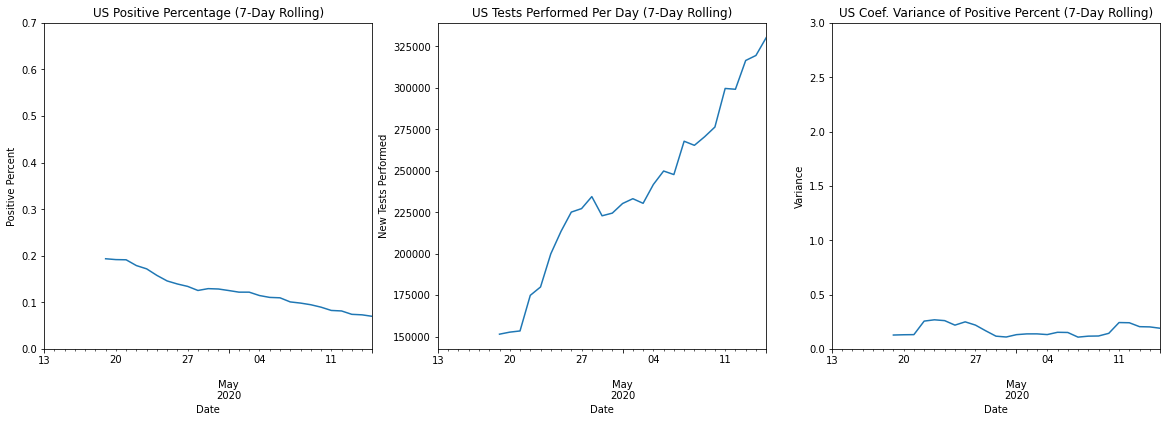

In [22]:
fig, axes = fig, axes = plt.subplots(1, 3, figsize=(20, 6))

state = 'US'

ax = series.plot.line(y='Rolling', ax=axes[0], legend=False, ylim=(0,.7))
ax.set_ylabel('Positive Percent')
ax.set_title(state + ' Positive Percentage (7-Day Rolling)')

ax = series.plot.line(y='TestAvailability', ax = axes[1], legend=False)
ax.set_ylabel('New Tests Performed')
ax.set_title(state + ' Tests Performed Per Day (7-Day Rolling)')

ax = series.plot.line(y='RollingCV', ax=axes[2], legend=False, ylim=(0,3))
ax.set_ylabel('Variance')
ax.set_title(state + ' Coef. Variance of Positive Percent (7-Day Rolling)')

In [24]:
raw_daily_covid_report = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_daily_reports_us/' + lastdate + '.csv')
raw_state_population_report = pd.read_csv('http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#')
raw_state_areas = pd.read_csv('https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/state-areas.csv')
raw_state_political_parties = pd.read_csv('/Users/davidmorton/Downloads/raw_data.csv')
raw_state_abbreviations = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

In [43]:
daily_covid_report = raw_daily_covid_report.copy()
state_population_report = raw_state_population_report.copy()
state_areas = raw_state_areas.copy()
state_political_parties = raw_state_political_parties.copy()
state_abbreviations = raw_state_abbreviations.copy()

daily_covid_report = daily_covid_report[daily_covid_report['Province_State'].isin(state_areas['state'].tolist())]
daily_covid_report = daily_covid_report.drop(['People_Hospitalized', 'Hospitalization_Rate', 'Recovered'], axis=1).dropna()
daily_covid_report['PercentPositive'] = daily_covid_report['Confirmed'].div(daily_covid_report['People_Tested']) * 100

daily_covid_report.index = daily_covid_report['Province_State']

state_areas.index = state_areas['state']
daily_covid_report['Area'] = state_areas['area (sq. mi)']

state_population_report.index = state_population_report['NAME']
daily_covid_report['Population'] = state_population_report['POPESTIMATE2019']

daily_covid_report['PopulationDensity'] = daily_covid_report['Population'].div(daily_covid_report['Area'])

state_abbreviations.index = state_abbreviations['State']

daily_covid_report['StateId'] = state_abbreviations['Abbreviation']

#daily_covid_report.describe()
daily_covid_report = daily_covid_report[daily_covid_report['PercentPositive'] < 100]

fig = go.Figure(data=go.Choropleth(
    locations=daily_covid_report['StateId'], # Spatial coordinates
    z = daily_covid_report['PercentPositive'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Percent Positive"
))

fig.update_layout(
    title_text = 'Percent Positive USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

fig2 = go.Figure(data=go.Choropleth(
    locations=daily_covid_report['StateId'], # Spatial coordinates
    z = daily_covid_report['Testing_Rate'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Rainbow',
    colorbar_title = "People Tested per 100,000"
))

fig2.update_layout(
    title_text = 'Testing Rate',
    geo_scope='usa', # limite map scope to USA
)

fig2.show()

In [17]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_governors', header=1)

In [18]:
governors = tables[0]
governors = governors.drop(['Portrait', 'Party'], axis=1)
governors = governors.set_index(['State'], drop=False).copy()
governors['Party.1']['Minnesota'] = 'Democratic'
governors['Party.1']['West Virginia'] = 'Republican'
governors

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,Governor,Party.1,Born,Prior public experience,Inauguration,End of term,Past governors,Unnamed: 10
State,,,,,,,,,
Alabama,Alabama,Kay Ivey,Republican,(age 75),"Lieutenant Governor, Treasurer","April 10, 2017",2023,List,NaN
Alaska,Alaska,Mike Dunleavy,Republican,(age 59),Alaska Senate,"December 3, 2018",2022,List,NaN
Arizona,Arizona,Doug Ducey,Republican,(age 56),Treasurer,"January 5, 2015",2023 (term limits),List,NaN
Arkansas,Arkansas,Asa Hutchinson,Republican,(age 69),Under Secretary of Homeland Security for Borde...,"January 13, 2015",2023 (term limits),List,NaN
California,California,Gavin Newsom,Democratic,(age 52),"Lieutenant Governor, Mayor of San Francisco","January 7, 2019",2023,List,NaN
Colorado,Colorado,Jared Polis,Democratic,(age 45),"U.S. House, Colorado State Board of Education","January 8, 2019",2023,List,NaN
Connecticut,Connecticut,Ned Lamont,Democratic,(age 66),Greenwich Selectman,"January 9, 2019",2023,List,NaN
Delaware,Delaware,John Carney,Democratic,(age 63),"U.S. House, Lieutenant Governor","January 17, 2017",2021,List,NaN
Florida,Florida,Ron DeSantis,Republican,(age 41),U.S. House,"January 8, 2019",2023,List,NaN


In [19]:
governors['IsRepublican'] = (governors['Party.1'] == 'Republican').astype(int)

In [20]:
daily_covid_report['RepublicanLeader'] = governors['IsRepublican']

In [21]:
politicized_daily_report = daily_covid_report.dropna().copy()

politicized_daily_report.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Province_State     50 non-null     object 
 1   Country_Region     50 non-null     object 
 2   Last_Update        50 non-null     object 
 3   Lat                50 non-null     float64
 4   Long_              50 non-null     float64
 5   Confirmed          50 non-null     int64  
 6   Deaths             50 non-null     int64  
 7   Active             50 non-null     float64
 8   FIPS               50 non-null     int64  
 9   Incident_Rate      50 non-null     float64
 10  People_Tested      50 non-null     float64
 11  Mortality_Rate     50 non-null     float64
 12  UID                50 non-null     int64  
 13  ISO3               50 non-null     object 
 14  Testing_Rate       50 non-null     float64
 15  PercentPositive    50 non-null     float64
 16  Area               50 

In [22]:
state_locations = pd.read_html('https://www.latlong.net/category/states-236-14.html')[0]

In [23]:
def fixname(x):
    r = x.split(',')[0]
    tokens = r.split(' ')
    if 'State' in tokens:
        tokens.remove('State')
    return ' '.join(tokens)

state_locations['Place Name'] = state_locations['Place Name'].apply(fixname)


In [24]:
state_locations.index = state_locations['Place Name']

In [25]:
politicized_daily_report['Latitude'] = state_locations['Latitude']
politicized_daily_report['Longitude'] = state_locations['Longitude']


In [26]:
politicized_daily_report

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Active,FIPS,Incident_Rate,...,ISO3,Testing_Rate,PercentPositive,Area,Population,PopulationDensity,StateId,RepublicanLeader,Latitude,Longitude
Province_State,,,,,,,,,,,,,,,,,,,,,
Alabama,Alabama,US,2020-05-13 03:32:30,32.3182,-86.9023,10464,435,10029.0,1,223.165491,...,USA,2841.137265,7.854794,52423,4903185,93.531179,AL,1.0,32.318230,-86.902298
Alaska,Alaska,US,2020-05-13 03:32:30,61.3707,-152.4044,383,10,39.0,2,64.073717,...,USA,5012.304496,1.278328,656425,731545,1.114438,AK,1.0,66.160507,-153.369141
Arizona,Arizona,US,2020-05-13 03:32:30,33.7298,-111.4312,11736,562,8265.0,4,161.237207,...,USA,1687.687542,9.553736,114006,7278717,63.845034,AZ,1.0,34.048927,-111.093735
Arkansas,Arkansas,US,2020-05-13 03:32:30,34.9697,-92.3731,4164,95,849.0,5,160.832622,...,USA,2720.867724,5.911078,53182,3017804,56.744838,AR,1.0,34.799999,-92.199997
California,California,US,2020-05-13 03:32:30,36.1162,-119.6816,70978,2879,68099.0,6,181.026519,...,USA,2635.568403,6.868595,163707,39512223,241.359398,CA,0.0,36.778259,-119.417931
Colorado,Colorado,US,2020-05-13 03:32:30,39.0598,-105.3111,20157,1010,16033.0,8,355.702579,...,USA,1917.426956,18.551037,104100,5758736,55.319270,CO,0.0,39.113014,-105.358887
Connecticut,Connecticut,US,2020-05-13 03:32:30,41.5978,-72.7554,34333,3041,25879.0,9,962.979979,...,USA,3882.548586,24.802780,5544,3565287,643.089286,CT,0.0,41.599998,-72.699997
Delaware,Delaware,US,2020-05-13 03:32:30,39.3185,-75.5071,6741,237,3702.0,10,692.262191,...,USA,3418.795519,20.248716,1954,973764,498.343910,DE,0.0,39.000000,-75.500000
Florida,Florida,US,2020-05-13 03:32:30,27.7663,-81.6868,41923,1779,40144.0,12,197.446324,...,USA,2729.782675,7.233042,65758,21477737,326.617856,FL,1.0,27.994402,-81.760254


In [44]:
X = politicized_daily_report[['Latitude']]
y = politicized_daily_report[['PercentPositive']]

est = sm.OLS(y, sm.add_constant(X)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        PercentPositive   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                 0.0004555
Date:                Fri, 15 May 2020   Prob (F-statistic):              0.983
Time:                        20:41:43   Log-Likelihood:                -168.04
No. Observations:                  50   AIC:                             340.1
Df Residuals:                      48   BIC:                             343.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9025      6.146      1.774      0.082      -1.455      23.260
Latitude       0.0033      0.153      0.021      0.983      -0.304       0.310
==============================================================================
Omnibus:                        8.312   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.621
Skew:                           0.924   Prob(JB):                       0.0221
Kurtosis:                       3.494   Cond. No.                         246.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

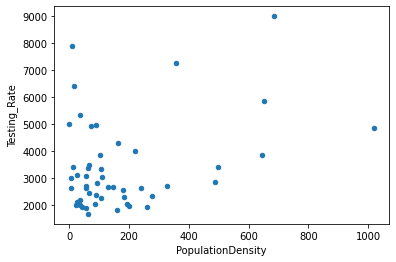

In [28]:
politicized_daily_report.plot.scatter(x='PopulationDensity', y='Testing_Rate')